## Depict

In [1]:
import logging, sys
import torch
import numpy as np
import cupy as cp
from numpy.typing import NDArray
import matplotlib.pyplot as plt

from utils import general_utils as utilities
from classes import point_cloud, scene
from classes.cameras import Camera
from tqdm import tqdm

from optix_raycasting import optix_utils as u_ox
from optix_raycasting import render_optix as r_ox
import optix as ox

device = 'cuda'

from omegaconf import OmegaConf

config = OmegaConf.create()
config.merge_with({
    "scene": {
        "source_path":              "/",
        "images":                   "images",
        "data_device":              "cuda",
        "white_background":         False,
        "eval":                     False,

        "load_allres":              False,
        "resolution":               -1,
        "train_resolution_scales":  [1.0], #Be careful if load_allres==false only one is loaded
        "test_resolution_scales":   [1.0]
    },
    "pointcloud": {
        "data_type": "float32",
        "init_method": None,
    },
    "training": {
        "max_prim_slice": 1024,
        "supersampling_x": 1,
        "supersampling_y": 1
    },
    "save": {
        "models": None
    },
})


cloud = point_cloud.PointCloud( data_type=config.pointcloud.data_type, device=device )
opt_scene = scene.Scene(
    config=config,
    pointcloud=cloud,
    train_resolution_scales=config.scene.train_resolution_scales,
    test_resolution_scales=config.scene.test_resolution_scales,
)  
cloud.num_sph_gauss = 0
cloud.harmonic_number = 0

# # thick tensor
# cloud.set_gaussian(
#     torch.tensor([0.0, 0.0, 0.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([5.0, 1.0, 5.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([1.0, 0.0, 0.0, 0.0],  dtype=torch.float32, device="cuda"),
#     torch.tensor([1.0, 1.0, 1.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([100.0],                 dtype=torch.float32, device="cuda")
# )

# 22.5 rotation
cloud.set_gaussian(
    torch.tensor([0.0, 0.0, 0.0],       dtype=torch.float32, device="cuda"),
    torch.tensor([5.0, 0.1, 5.0],       dtype=torch.float32, device="cuda"),
    torch.tensor([0.9807853, 0, 0, 0.1950903],  dtype=torch.float32, device="cuda"),
    torch.tensor([1.0, 1.0, 1.0],       dtype=torch.float32, device="cuda"),
    torch.tensor([100.0],                 dtype=torch.float32, device="cuda")
)

# # thin tensor
# cloud.set_gaussian(
#     torch.tensor([0.0, 0.0, 0.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([0.3, 3e-4, 0.3],       dtype=torch.float32, device="cuda"),
#     torch.tensor([1.0, 0.0, 0.0, 0.0],  dtype=torch.float32, device="cuda"),
#     torch.tensor([1.0, 1.0, 1.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([100.0],                 dtype=torch.float32, device="cuda")
# )



rot = np.array([
    [1, 0, 0],
    [0, 0, 1],
    [0, 1, 0]
])
pos = np.array([0,-100,0], dtype=np.float32)
W2C = np.zeros((4, 4))
W2C[:3, :3] = rot
W2C[:3, 3] = pos
W2C[3, 3] = 1
Rt = np.linalg.inv(W2C)
R = Rt[:3, :3].transpose()
T = Rt[:3, 3]

H = 5
W = 5
# one offset to right
target_image = torch.zeros( (H, W, 3), dtype=torch.float32, device="cuda" )
target_image[2,3] = torch.tensor((0.5, 0.5, 0.5), dtype=torch.float32, device="cuda")

camera = Camera(
    0, # id
    R, # U,V,W
    T, # position
    0.5, 0.5, # fov 
    target_image.swapdims(0,2).swapdims(1,2), # to configure height and width, create target image
    None, None, None
)

################################################################################
PointCloud initialization
PointCloud: data type:  torch.float32


In [2]:
# Run only once
logging.basicConfig(stream=sys.stdout, level= logging.INFO)
log = logging.getLogger()

logger = ox.Logger(log)
ctx = ox.DeviceContext(validation_mode=False, log_callback_function=logger, log_callback_level=4)
ctx.cache_enabled = False

pipeline_options = ox.PipelineCompileOptions(traversable_graph_flags=ox.TraversableGraphFlags.ALLOW_SINGLE_GAS,
                                                num_payload_values=1,
                                                num_attribute_values=0,
                                                exception_flags=ox.ExceptionFlags.NONE,
                                                pipeline_launch_params_variable_name="params")
module_fwd = u_ox.create_module(ctx, pipeline_options,stage="forward")
program_grps_fwd = u_ox.create_program_groups(ctx, module_fwd)
pipeline_fwd = u_ox.create_pipeline(ctx, program_grps_fwd, pipeline_options)
module_bwd = u_ox.create_module(ctx, pipeline_options,stage="backward")
program_grps_bwd = u_ox.create_program_groups(ctx, module_bwd)
pipeline_bwd = u_ox.create_pipeline(ctx, program_grps_bwd, pipeline_options)
with torch.no_grad():
    cp_positions,cp_scales,cp_quaternion,cp_densities = utilities.torch2cupy(opt_scene.pointcloud.positions,
                                                                        opt_scene.pointcloud.get_scale(), opt_scene.pointcloud.get_normalized_quaternion(),
                                                                        opt_scene.pointcloud.densities)
L1,L2,L3=u_ox.quaternion_to_rotation( cp_quaternion )
bboxes = u_ox.compute_ellipsoids_bbox( cp_positions, cp_scales, L1, L2, L3, cp_densities )
gas = u_ox.create_acceleration_structure( ctx, bboxes )

In [3]:
update=True
supersampling=(config.training.supersampling_x,config.training.supersampling_y)
buffer_size=supersampling[0]*supersampling[1]*H*W*config.training.max_prim_slice
hit_prim_idx=cp.zeros((buffer_size),dtype=cp.int32)

settings = r_ox.RenderOptixSettings(
    ctx, update, gas, program_grps_fwd, pipeline_fwd,
    program_grps_bwd, pipeline_bwd, camera,
    config.training.max_prim_slice,opt_scene.pointcloud.num_sph_gauss, iteration=0, 
    jitter=False, rnd_sample=False,
    supersampling=(config.training.supersampling_x,config.training.supersampling_y),
    white_background=config.scene.white_background,
    hit_prim_idx=hit_prim_idx
)

(positions, scales, normalized_quaternions, densities, color_features, sph_gauss_features, 
 bandwidth_sharpness, lobe_axis) = opt_scene.pointcloud.get_data()

image, ray_bbox, ray_normals, ray_density, ray_depth=r_ox.RenderOptixFunction.apply(
    positions, scales, normalized_quaternions, densities, color_features,
    sph_gauss_features, bandwidth_sharpness, lobe_axis, settings
)

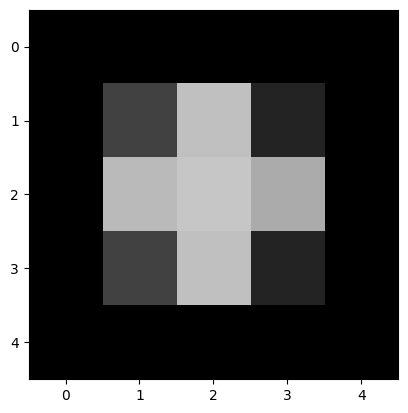

In [4]:
img: NDArray = image.detach().cpu().numpy().reshape(5,5,3)

plt.imshow(img)

In [5]:
image.max()

tensor(0.7802, device='cuda:0', grad_fn=<MaxBackward1>)

## Plot Error Rate

In [6]:
import logging, sys
import torch
import numpy as np
import cupy as cp
from numpy.typing import NDArray
import matplotlib.pyplot as plt

from utils import general_utils as utilities
from classes import point_cloud, scene
from classes.cameras import Camera
from tqdm import tqdm

from optix_raycasting import optix_utils as u_ox
from optix_raycasting import render_optix as r_ox
import optix as ox

device = 'cuda'

from omegaconf import OmegaConf

config = OmegaConf.create()
config.merge_with({
    "scene": {
        "source_path":              "/",
        "images":                   "images",
        "data_device":              "cuda",
        "white_background":         False,
        "eval":                     False,

        "load_allres":              False,
        "resolution":               -1,
        "train_resolution_scales":  [1.0], #Be careful if load_allres==false only one is loaded
        "test_resolution_scales":   [1.0]
    },
    "pointcloud": {
        "data_type": "float32",
        "init_method": None,
    },
    "training": {
        "max_prim_slice": 1024,
        "supersampling_x": 1,
        "supersampling_y": 1
    },
    "save": {
        "models": None
    },
})


cloud = point_cloud.PointCloud( data_type=config.pointcloud.data_type, device=device )
opt_scene = scene.Scene(
    config=config,
    pointcloud=cloud,
    train_resolution_scales=config.scene.train_resolution_scales,
    test_resolution_scales=config.scene.test_resolution_scales,
)  
cloud.num_sph_gauss = 0
cloud.harmonic_number = 0

# # zero rotation big gaussian
# cloud.add_gaussian(
#     MU.float3(0, 0, 0),
#     MU.float3(3, 1, 3),
#     Quaternion.normalize( Quaternion(1, 0, 0, 0) ),
#     MU.float3(1,1,1),
#     0.5
# )

# # zero rotation
# cloud.add_gaussian(
#     MU.float3(0, 0, 0),
#     MU.float3(0.03, 1, 0.03),
#     Quaternion.normalize( Quaternion(1, 0, 0, 0) ),
#     MU.float3(1,1,1),
#     0.5
# )
# cloud.set_gaussian(
#     torch.tensor([0.0, 0.0, 0.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([0.03, 1, 0.03],       dtype=torch.float32, device="cuda"),
#     torch.tensor([1.0, 0.0, 0.0, 0.0],  dtype=torch.float32, device="cuda"),
#     torch.tensor([1.0, 1.0, 1.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([0.5],                 dtype=torch.float32, device="cuda")
# )

# # zero rotation
# cloud.add_gaussian(
#     MU.float3(0, 0, 0),
#     MU.float3(0.3, 1, 0.3),
#     Quaternion.normalize( Quaternion(1, 0, 0, 0) ),
#     MU.float3(1,1,1),
#     0.5
# )
# cloud.set_gaussian(
#     torch.tensor([0.0, 0.0, 0.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([5.0, 1.0, 5.0],     dtype=torch.float32, device="cuda"),
#     torch.tensor([1.0, 0.0, 0.0, 0.0],  dtype=torch.float32, device="cuda"),
#     torch.tensor([1.0, 1.0, 1.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([100.0],                 dtype=torch.float32, device="cuda")
# )


# # 22.5° rotation
# cloud.add_gaussian(
#     MU.float3(0, 0, 0),
#     MU.float3(0.3, .1, 0.3),
#     Quaternion.normalize( Quaternion(0.9807853, 0, 0, 0.1950903) ),
#     MU.float3(1,1,1),
#     0.5
# )
cloud.set_gaussian(
    torch.tensor([0.0, 0.0, 0.0],       dtype=torch.float32, device="cuda"),
    torch.tensor([5.0, 0.1, 5.0],       dtype=torch.float32, device="cuda"),
    torch.tensor([0.9807853, 0, 0, 0.1950903],  dtype=torch.float32, device="cuda"),
    torch.tensor([1.0, 1.0, 1.0],       dtype=torch.float32, device="cuda"),
    torch.tensor([100.0],                 dtype=torch.float32, device="cuda")
)

# # 45° rotation
# cloud.add_gaussian(
#     MU.float3(0, 0, 0),
#     MU.float3(.4, .1, .3),
#     Quaternion.normalize( Quaternion(0.9238795, 0, 0, 0.3826834) ),
#     MU.float3(1,1,1),
#     0.5
# )
# cloud.set_gaussian(
#     torch.tensor([0.0, 0.0, 0.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([0.3, 1.0, 0.3],       dtype=torch.float32, device="cuda"),
#     torch.tensor([0.9238795, 0, 0, 0.3826834],  dtype=torch.float32, device="cuda"),
#     torch.tensor([1.0, 1.0, 1.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([100.0],                 dtype=torch.float32, device="cuda")
# )

# # 67.5° rotation
# cloud.add_gaussian(
#     MU.float3(0, 0, 0),
#     MU.float3(.7, .1, .3), 
#     Quaternion.normalize( Quaternion(0.8314696, 0, 0, 0.5555702) ),
#     MU.float3(1,1,1),
#     0.5
# )

# # 89° rotation
# cloud.add_gaussian(
#     MU.float3(0, 0, 0),
#     MU.float3(1, .1, .3),
#     Quaternion.normalize( Quaternion(0.7132504, 0, 0, 0.7009093) ),
#     MU.float3(1,1,1),
#     0.5
# )
# cloud.set_gaussian(
#     torch.tensor([0.0, 0.0, 0.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([1.0, 0.1, 0.3],       dtype=torch.float32, device="cuda"),
#     torch.tensor([0.7132504, 0, 0, 0.7009093],  dtype=torch.float32, device="cuda"),
#     torch.tensor([1.0, 1.0, 1.0],       dtype=torch.float32, device="cuda"),
#     torch.tensor([100.0],                 dtype=torch.float32, device="cuda")
# )


rot = np.array([
    [1, 0, 0],
    [0, 0, 1],
    [0, 1, 0]
])
pos = np.array([0,-100,0], dtype=np.float32)
W2C = np.zeros((4, 4))
W2C[:3, :3] = rot
W2C[:3, 3] = pos
W2C[3, 3] = 1
Rt = np.linalg.inv(W2C)
R = Rt[:3, :3].transpose()
T = Rt[:3, 3]

H = 5
W = 5
target_image = torch.zeros( (H, W, 3), dtype=torch.float32, device="cuda" )
# one offset to right
# target_image[2,3] = torch.tensor((0.5, 0.5, 0.5), dtype=torch.float32, device="cuda")
# middle
target_image[2,2] = torch.tensor((0.5, 0.5, 0.5), dtype=torch.float32, device="cuda")

cam = Camera(
    0, # id
    R, # U,V,W
    T, # position
    0.5, 0.5, # fov 
    target_image.swapdims(0,2).swapdims(1,2), # to configure height and width, create target image
    None, None, None
)

# Run only once
logging.basicConfig(stream=sys.stdout, level= logging.INFO)
log = logging.getLogger()

logger = ox.Logger(log)
ctx = ox.DeviceContext(validation_mode=False, log_callback_function=logger, log_callback_level=4)
ctx.cache_enabled = False

pipeline_options = ox.PipelineCompileOptions(traversable_graph_flags=ox.TraversableGraphFlags.ALLOW_SINGLE_GAS,
                                                num_payload_values=1,
                                                num_attribute_values=0,
                                                exception_flags=ox.ExceptionFlags.NONE,
                                                pipeline_launch_params_variable_name="params")
module_fwd = u_ox.create_module(ctx, pipeline_options,stage="forward")
program_grps_fwd = u_ox.create_program_groups(ctx, module_fwd)
pipeline_fwd = u_ox.create_pipeline(ctx, program_grps_fwd, pipeline_options)
module_bwd = u_ox.create_module(ctx, pipeline_options,stage="backward")
program_grps_bwd = u_ox.create_program_groups(ctx, module_bwd)
pipeline_bwd = u_ox.create_pipeline(ctx, program_grps_bwd, pipeline_options)
with torch.no_grad():
    cp_positions,cp_scales,cp_quaternion,cp_densities = utilities.torch2cupy(opt_scene.pointcloud.positions,
                                                                        opt_scene.pointcloud.get_scale(), opt_scene.pointcloud.get_normalized_quaternion(),
                                                                        opt_scene.pointcloud.densities)
L1,L2,L3=u_ox.quaternion_to_rotation( cp_quaternion )
bboxes = u_ox.compute_ellipsoids_bbox( cp_positions, cp_scales, L1, L2, L3, cp_densities )
gas = u_ox.create_acceleration_structure( ctx, bboxes )


cloud_optimizer = torch.optim.Adam( [cloud.positions, cloud.scales, cloud.quaternions] )

loss_fn = torch.nn.functional.l1_loss

steps = 1_000 # 10_000
y_sizes = np.zeros(steps, dtype=np.float32)

pos_grads = np.zeros((steps,3), dtype=np.float32)
size_grads = np.zeros((steps, 3), dtype=np.float32)
quaternion_grads = np.zeros((steps, 4), dtype=np.float32)


_sub_st = steps // 10
y_sizes[:_sub_st] = 10 ** np.linspace(1, 0, _sub_st)           # from 10 to 1.0
y_sizes[_sub_st:2*_sub_st] = 1 / (10 ** np.linspace(0, 1, _sub_st))     # from 1.0 to 0.1
y_sizes[2*_sub_st:] = 10 ** -np.linspace(1, 5, steps-2*_sub_st)         # from 0.1 to 1e-5

_distances = np.zeros(steps, dtype=float)

for i, y_size in tqdm( enumerate( list( y_sizes ) ) ):
    # print(i)
    # update size
    with torch.no_grad():
        cloud.scales[0, 1] = torch.log( torch.tensor(y_size) )
    
    # render
    update=True
    supersampling=(config.training.supersampling_x,config.training.supersampling_y)
    buffer_size=supersampling[0]*supersampling[1]*H*W*config.training.max_prim_slice
    hit_prim_idx=cp.zeros((buffer_size),dtype=cp.int32)

    settings = r_ox.RenderOptixSettings(
        ctx, update, gas, program_grps_fwd, pipeline_fwd,
        program_grps_bwd, pipeline_bwd, cam,
        config.training.max_prim_slice,opt_scene.pointcloud.num_sph_gauss, iteration=0, 
        jitter=False, rnd_sample=False,
        supersampling=(config.training.supersampling_x,config.training.supersampling_y),
        white_background=config.scene.white_background,
        hit_prim_idx=hit_prim_idx
    )

    (positions, scales, normalized_quaternions, densities, color_features, sph_gauss_features, 
    bandwidth_sharpness, lobe_axis) = opt_scene.pointcloud.get_data()

    image, ray_bbox, ray_normals, ray_density, ray_depth=r_ox.RenderOptixFunction.apply(
        positions, scales, normalized_quaternions, densities, color_features,
        sph_gauss_features, bandwidth_sharpness, lobe_axis, settings
    )
    
    render = image.reshape(H,W,3)
    #

    loss = loss_fn( render, target_image )
    loss.backward()

    # positive y gradient means away from camera
    pos_grads[i] = cloud.positions.grad[0].detach().cpu().numpy()

    size_grads[i] = cloud.scales.grad[0].detach().cpu().numpy()
    
    quaternion_grads[i] = cloud.quaternions.grad[0].detach().cpu().numpy()
    
    cloud.positions.grad[...]   = 0
    cloud.scales.grad[...]      = 0
    cloud.quaternions.grad[...] = 0

################################################################################
PointCloud initialization
PointCloud: data type:  torch.float32


1000it [00:29, 33.60it/s]


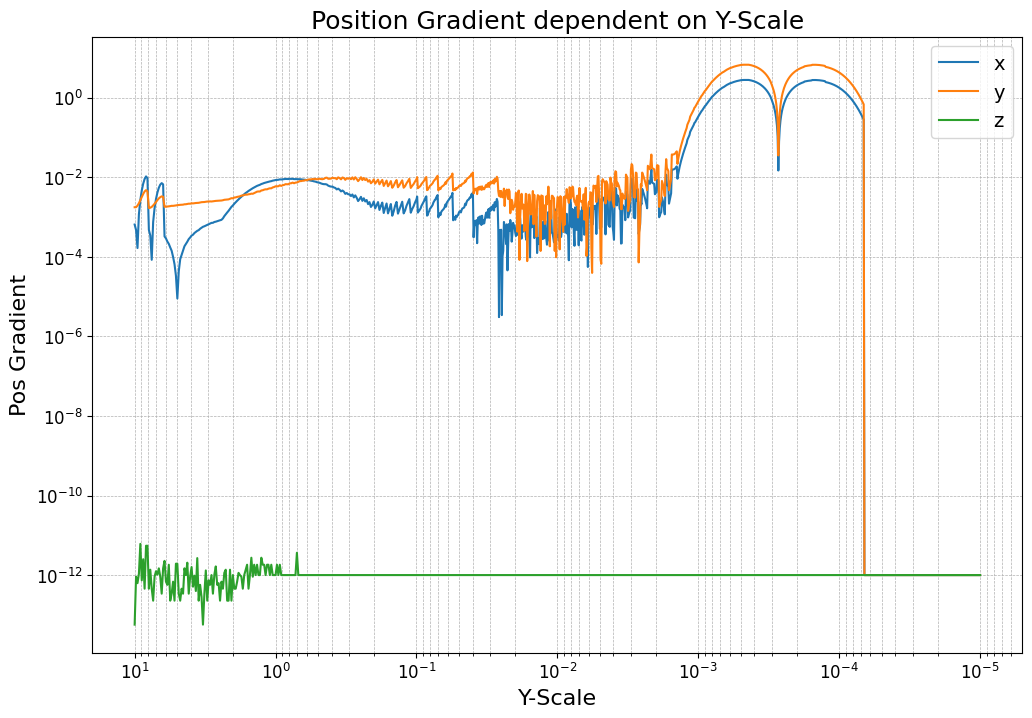

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

f = plt.figure(figsize=(12, 8))

pos_grads_plot = pos_grads.copy()
pos_grads_plot = np.abs( pos_grads_plot )
# pos_grads_plot[ pos_grads != pos_grads ] = 1e12 # remove nans
pos_grads_plot[ pos_grads == 0 ] = 1e-12 # remove zeros (should not happen)

plt.plot( y_sizes, pos_grads_plot[:,0], label="x" )
plt.plot( y_sizes, pos_grads_plot[:,1], label="y" )
plt.plot( y_sizes, pos_grads_plot[:,2], label="z" )
plt.gca().invert_xaxis()    # from thick to thin
plt.legend(fontsize=14)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Background grid
plt.xscale("log") # gradients can get very big, so use log scale
if (pos_grads_plot <= 0).any():
    plt.yscale("linear")
else:
    plt.yscale("log")
    
# plt.title('Position Gradient dependent on Y-Scale. In theory this should be almost constant.')
plt.title('Position Gradient dependent on Y-Scale', fontsize=18)
plt.xlabel("Y-Scale", fontsize=16)
plt.ylabel('Pos Gradient', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

from pathlib import Path
path = Path("/home/user1/Documents/")
plt.savefig( str(path / f"numerical_position_issues_RG.png") )
plt.show()
# plt.close()

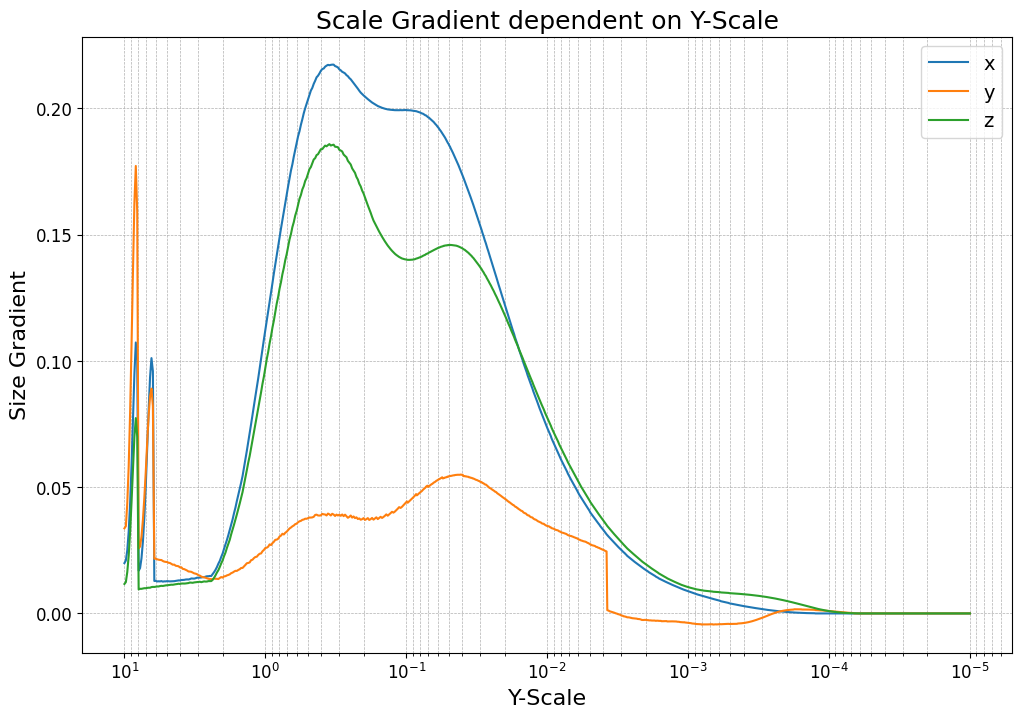

In [8]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12, 8))

size_grads_plot = size_grads.copy()
# size_grads_plot = np.abs( size_grads_plot )
# size_grads_plot[ size_grads != size_grads ] = 1e2 # remove nans
# size_grads_plot[ size_grads == 0 ] = 1e-12 # remove zeros (should not happen)

plt.plot( y_sizes, size_grads_plot[:,0], label="x" )
plt.plot( y_sizes, size_grads_plot[:,1], label="y" )
plt.plot( y_sizes, size_grads_plot[:,2], label="z" )
plt.gca().invert_xaxis()    # from thick to thin
plt.legend(fontsize=14)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Background grid
plt.xscale("log") # gradients can get very big, so use log scale
if (size_grads_plot <= 0).any():
    plt.yscale("linear")
else:
    plt.yscale("log")
    
plt.title('Scale Gradient dependent on Y-Scale', fontsize=18)
plt.xlabel("Y-Scale", fontsize=16)
plt.ylabel('Size Gradient', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

from pathlib import Path
path = Path("/home/user1/Documents/Master/worktree/gaussian_renderer/tmp")
# plt.savefig( str(path / f"numerical_issues_solved.png") )
plt.show()
# plt.close()

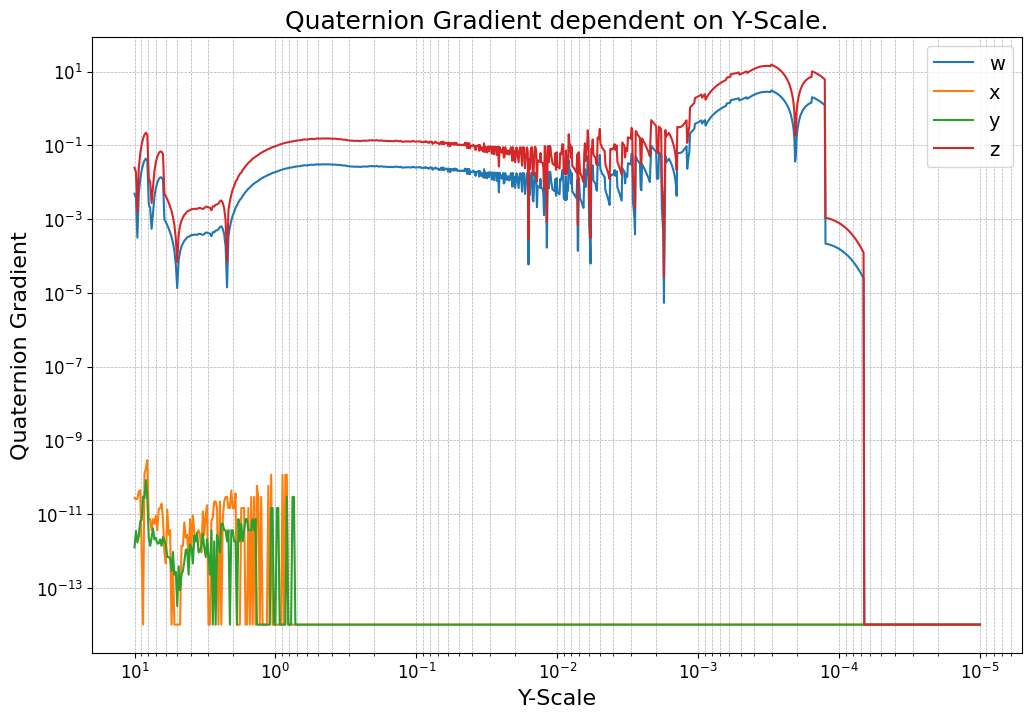

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

f = plt.figure(figsize=(12, 8))

quaternion_grads_plot = quaternion_grads.copy()
quaternion_grads_plot = np.abs( quaternion_grads_plot )
# quaternion_grads_plot[ quaternion_grads != quaternion_grads ] = 1e2 # remove nans
quaternion_grads_plot[ quaternion_grads == 0 ] = 1e-14 # remove zeros (should not happen)

plt.plot( y_sizes, quaternion_grads_plot[:,0], label="w" )
plt.plot( y_sizes, quaternion_grads_plot[:,1], label="x" )
plt.plot( y_sizes, quaternion_grads_plot[:,2], label="y" )
plt.plot( y_sizes, quaternion_grads_plot[:,3], label="z" )
plt.gca().invert_xaxis()    # from thick to thin
plt.legend(fontsize=14)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Background grid
plt.xscale("log") # gradients can get very big, so use log scale
if (quaternion_grads_plot <= 0).any():
    plt.yscale("linear")
else:
    plt.yscale("log")
    
plt.title('Quaternion Gradient dependent on Y-Scale.', fontsize=18)
plt.xlabel("Y-Scale", fontsize=16)
plt.ylabel('Quaternion Gradient', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

from pathlib import Path
path = Path("/home/user1/Documents/Master/worktree/gaussian_renderer/tmp")
# plt.savefig( str(path / f"numerical_issues_solved.png") )
plt.show()
# plt.close()